# AIoT-Based Digits Classification

Advanced Topics in Communications Electronics \
Department of Electrical and Computer Engineering \
Technical University of Munich 

By Zain Amir Zaman \
Matriculation ID: 03754975

## Note: Please upload the dataset files train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz to the Files section.

# Libraries

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy.stats import mode
import numpy as np
#from mnist import MNIST
from time import time
import pandas as pd
import os
from tensorflow.keras.datasets import mnist

import random
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sb
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC, LinearSVC
import warnings
warnings.filterwarnings('ignore')
import random
import glob
import tensorflow as tf
import gzip

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten

# Fixes error in which the title of a figure cannot be set
from importlib import reload
plt=reload(plt)

Mounted at /content/gdrive


# Functions

In [14]:
# For extraction of digits during creation of dataset

def autocrop(bw_image):
  w = bw_image.shape[0]
  h = bw_image.shape[1]

  x1, x2, y1, y2 = [0, 0, 0, 0]
  x1_set, x2_set, y1_set, y2_set = [False, False, False, False]

  for r in range(0, w):
    for c in range(0, h):

      # Find x1
      if bw_image[r, c][0] == 0:
        if x1 == 0:
          x1 = c
          #x1_set = True
        elif c < x1:
          x1 = c

      # Find x2
      if bw_image[r, c][0] == 0:
        if x2 == 0:
          x2 = c
          #x2_set = True
        elif c > x2:
          x2 = c

      # Find y1
      if bw_image[r, c][0] == 0:
        if y1 == 0:
          y1 = r
          #x1_set = True
        elif r < y1:
          y1 = r
      
     # Find y2
      if bw_image[r, c][0] == 0:
        if y2 == 0:
          y2 = r
          #x1_set = True
        elif r > y2:
          y2 = r
  
  return x1, x2, y1, y2

# For normalisation of my contributed images

def mnist_style_normalise(img, thresh_val):

  # Apply thresholding to get bitonal (2-bit/binary) image

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_bw = cv2.threshold(img, thresh_val, 255, cv2.THRESH_BINARY)
  img_bw = cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB)

  # Crop image

  x1, x2, y1, y2 = autocrop(img_bw)
  img_bw = img_bw[y1:y2, x1:x2]

  # Downsize to 20x20 px while maintaining aspect ratio

  max_dim = max(img_bw.shape[0], img_bw.shape[1])
  scale_factor = 20/max_dim
  width = int(img_bw.shape[1] * scale_factor)
  height = int(img_bw.shape[0] * scale_factor)
  dim = (width, height)
  img_resized = cv2.resize(img_bw, dim, interpolation = cv2.INTER_AREA)

  # Find centroid

  img_resized_2 = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # Convert to single channel grayscale image
  ret, img_resized_2 = cv2.threshold(img_resized_2, thresh_val, 255, cv2.THRESH_BINARY)
  M = cv2.moments(img_resized_2)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])

  # Position resized image in a blank 28x28 px canvas

  output_img = np.ones((28, 28, 3), np.uint8) * 255
  output_img_centre = [13, 13]

  w = img_resized.shape[1]
  h = img_resized.shape[0]

  for c in range(output_img_centre[0]-cY, output_img_centre[0]-cY+h):
    for r in range(output_img_centre[1]-cX, output_img_centre[1]-cX+w):
      output_img[c, r, :] = img_resized[c-(output_img_centre[0]-cY), r-(output_img_centre[1]-cX), :]

  return output_img

# Display an entire list of images in one go

def display_dataset(images):
  fig1 = plt.figure(figsize=(17, 17))
  columns = 30
  rows = 10
  idx = 0
  for i in range(0, columns*rows):
      img = images[i]
      ax = fig1.add_subplot(rows, columns, i+1)
      ax.title.set_text(idx)
      idx = idx + 1
      plt.imshow(img)

# To display a single image as a figure

def display_single(img):
  fig = plt.figure(figsize=(4, 4))
  plt.imshow(img)
  plt.show()
  plot_once = True

# Second pre-processing function for normalising collective dataset

def second_preprocessing(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                            cv2.THRESH_BINARY, 11, 2)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Upsizing (binary)

  resize_to = 30

  max_dim = max(img.shape[0], img.shape[1])
  scale_factor = resize_to/max_dim
  width = int(img.shape[1] * scale_factor)
  height = int(img.shape[0] * scale_factor)
  dim = (width, height)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)

  # Downsizing (grayscale values)

  resize_to = 28

  max_dim = max(img.shape[0], img.shape[1])
  scale_factor = resize_to/max_dim
  width = int(img.shape[1] * scale_factor)
  height = int(img.shape[0] * scale_factor)
  dim = (width, height)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # Converting to single colour channel

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Inverting

  img = cv2.bitwise_not(img)

  return img

# Dataset augmentation function. Supports random rotation and contrast change.

def augment(img, rotate, contrast):

  # Random rotation

  if rotate:
    angle = random.randint(-10, 10)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h))

  # Increase contrast randomly

  if contrast:
    c = random.uniform(1.0, 1.5)
    img = cv2.addWeighted(img, c, img, 0, 0)

  # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
  #                           cv2.THRESH_BINARY, 11, 2)

  return img

# Final step in the pre-processing pipeline. Returns a grayscale image.

def third_preprocessing(img, size):
  img = cv2.bitwise_not(img)
  img = cv2.resize(img, (size,size), interpolation = cv2.INTER_NEAREST)
  # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
  #                           cv2.THRESH_BINARY, 11, 2)
  img = cv2.bitwise_not(img)
  return img

def print_as_c_array(img):
  x = ""
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      x += str(img[i][j]) + ", "
  print(x)

def preprocess_mnist_for_cnn(img):
  
  # Crop image

  w = img.shape[0]
  h = img.shape[1]

  x1, x2, y1, y2 = [-1, -1, -1, -1]
  x1_set, x2_set, y1_set, y2_set = [False, False, False, False]

  for r in range(0, w):
    for c in range(0, h):

      # Find x1
      if img[r, c] == 0:
        if x1 == -1:
          x1 = c
          #x1_set = True
        elif c < x1:
          x1 = c

      # Find x2
      if img[r, c] == 0:
        if x2 == -1:
          x2 = c
          #x2_set = True
        elif c > x2:
          x2 = c

      # Find y1
      if img[r, c] == 0:
        if y1 == -1:
          y1 = r
          #x1_set = True
        elif r < y1:
          y1 = r
      
      # Find y2
      if img[r, c] == 0:
        if y2 == -1:
          y2 = r
          #x1_set = True
        elif r > y2:
          y2 = r

  img = img[y1:y2, x1:x2]

  # Downsize to 20x20 px while maintaining aspect ratio

  max_dim = max(img.shape[0], img.shape[1])
  scale_factor = 20/max_dim
  width = int(img.shape[1] * scale_factor)
  height = int(img.shape[0] * scale_factor)
  dim = (width, height)
  img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # Find centroid

  img_resized_2 = img_resized
  ret, img_resized_2 = cv2.threshold(img_resized_2, 127, 255, cv2.THRESH_BINARY)
  M = cv2.moments(img_resized_2)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])

  # Position resized image in a blank 28x28 px canvas

  output_img = np.ones((28, 28), np.uint8) * 0
  output_img_centre = [13, 13]

  w = img_resized.shape[1]
  h = img_resized.shape[0]

  for c in range(output_img_centre[0]-cY, output_img_centre[0]-cY+h):
    for r in range(output_img_centre[1]-cX, output_img_centre[1]-cX+w):
      output_img[c, r] = img_resized[c-(output_img_centre[0]-cY), r-(output_img_centre[1]-cX)]

  # Downsize to 14x14

  output_img = cv2.resize(output_img, (14,14), interpolation = cv2.INTER_NEAREST)

  return output_img

# Dataset preparation and pre-processing

In [30]:
img_dim = 28

def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

X_samples, y_samples = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
X_samples = X_samples.reshape(3000, 28, 28)

In [19]:
# Creating a dictionary to augment data

dataset = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
}

lengths = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
}

for i in range(X_samples.shape[0]):
  dataset[y_samples[i]].append(X_samples[i])

for k in range(0, len(dataset)):
  lengths[k] = lengths[k] + len(dataset[k])

In [28]:
# Augmentation

target_num_samples = 40000  # Set to 50000 for final run
num_samples = 0
iter = 0

while (num_samples < target_num_samples):

  for k in range(0, len(dataset)):
    for i in range(0, lengths[k]):
      dataset[k].append(augment(dataset[k][i], True, True))
      lengths[k] += 1

  # Re-calculate total number of samples

  num_samples = 0

  for k in range(len(lengths)):
    num_samples += lengths[k]

  iter += 1

  print("Iteration", iter, "Total number of samples: ", num_samples)

Iteration 1 Total number of samples:  6000
Iteration 2 Total number of samples:  12000
Iteration 3 Total number of samples:  24000
Iteration 4 Total number of samples:  48000


In [31]:
# Create monochannel dataset

dataset_mono = np.zeros((num_samples, img_dim, img_dim), dtype=np.uint8)   # prev int

i_start = 0
for key in dataset:
  for i in range(lengths[key]):
    dataset_mono[i+i_start] = dataset[key][i]
  i_start += lengths[key]

blanks = 0

for i in range(0, num_samples):
  all_zeros = not np.any(dataset_mono[i])
  if all_zeros:
    blanks += 1

print("Blanks:", blanks)

Blanks: 0


In [32]:
# Generate label vector. I have lengths dictionary. Can make use of that.

y_train_new = np.zeros((num_samples,1), dtype=int)  # Prev (num_samples,)

i_start = 0
for k in lengths:
  for i in range(i_start, i_start + lengths[k]):
    y_train_new[i] = k
  i_start = i_start + lengths[k]

# Reshape into 784 feature vector.

dataset_mono_new = dataset_mono.reshape((num_samples, img_dim*img_dim))

# Concatenate input and label vectors for random shuffling.

collective = np.concatenate((dataset_mono_new, y_train_new), axis=1)
np.random.shuffle(collective)

# Un-concatenate

dataset_mono_new = collective[:, :img_dim*img_dim]
y_train_new = collective[:, img_dim*img_dim]  # Shape: (196,)

# Check if there are any empty images

blanks = 0

for i in range(0, num_samples):
  all_zeros = not np.any(dataset_mono_new[i])
  if all_zeros:
    blanks += 1

print("Blanks:", blanks)

Blanks: 0


# Model 1: Support-Vector Machine (SVM)

In [33]:
train_samples = 20000
val_samples = int(train_samples * 0.2)

y_train = y_train_new[0:train_samples]
X_train = dataset_mono_new[0:train_samples]
y_test = y_train_new[train_samples:train_samples+val_samples]
X_test = dataset_mono_new[train_samples:train_samples+val_samples]

X_train = X_train.reshape((train_samples, img_dim*img_dim))
X_test = X_test.reshape((val_samples, img_dim*img_dim))
#y_train = y_train.reshape((y_train.shape[0]))
#y_test = y_test.reshape((y_test.shape[0]))

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (20000, 784)
X_test shape (4000, 784)
y_train shape (20000,)
y_test shape (4000,)


In [34]:
svm = LinearSVC(dual=False)
svm.fit(X_train, y_train)

LinearSVC(dual=False)

In [35]:
svm.coef_
svm.intercept_

array([-0.64540563, -0.02261528, -0.80507725, -0.83514089, -1.13584373,
       -0.86295242, -0.91142099, -0.54778616, -1.89167787, -1.1339079 ])

In [36]:
pred = svm.predict(X_test)
accuracy_score(y_test, pred)

0.67525

In [37]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

print("Testing accuracy on original MNIST dataset: ")

pred = svm.predict(X_train_mnist.reshape(60000, 28*28))
print("Training samples (60,000): ", accuracy_score(y_train_mnist, pred))

pred = svm.predict(X_test_mnist.reshape(10000, 28*28))
print("Test samples (10,000): ", accuracy_score(y_test_mnist, pred))

11501568/11490434 [==============================] - 0s 0us/step
Testing accuracy on original MNIST dataset: 
Training samples (60,000):  0.43156666666666665
Test samples (10,000):  0.4403


# Model 2: Neural Network

In [47]:
val_split = 0.1
train_samples = int(num_samples * (1-val_split))
val_samples = num_samples - train_samples

print("Number of samples:", num_samples)
print("Training samples:", train_samples)
print("Validation samples:", val_samples)

batch_size_var = 128  # 128

y_train = y_train_new[0:train_samples]
X_train = dataset_mono_new[0:train_samples]
y_test = y_train_new[train_samples:]
X_test = dataset_mono_new[train_samples:]

X_train = X_train.reshape(train_samples, img_dim, img_dim)
X_test = X_test.reshape(val_samples, img_dim, img_dim)
y_train = y_train.reshape((y_train.shape[0]))
y_test = y_test.reshape((y_test.shape[0]))

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
# X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

# one-hot format classes

# nb_classes = 10 # number of unique digits

# Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

# Convert y_train into one-hot format
temp = []
for i in range(len(y_train)):
    temp.append(np_utils.to_categorical(y_train[i], num_classes=10))
y_train = np.array(temp)
# Convert y_test into one-hot format
temp = []
for i in range(len(y_test)):    
    temp.append(np_utils.to_categorical(y_test[i], num_classes=10))
y_test = np.array(temp)

Number of samples: 48000
Training samples: 43200
Validation samples: 4800
X_train shape (43200, 28, 28)
X_test shape (4800, 28, 28)
y_train shape (43200,)
y_test shape (4800,)


In [48]:
# Create simple Neural Network model
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(20, activation='sigmoid')) # 20
# model.add(Dense(124, activation='sigmoid')) # 20
model.add(Dense(10, activation='softmax')) # 30
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                15700     
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

In [50]:
model.fit(X_train, y_train, epochs=20, 
          validation_data=(X_test,y_test))

Epoch 1/20
1350/1350 [==============================] - 3s 2ms/step - loss: 1.5049 - acc: 0.5694 - val_loss: 1.1966 - val_acc: 0.6592
Epoch 2/20
1350/1350 [==============================] - 3s 2ms/step - loss: 1.0448 - acc: 0.6962 - val_loss: 0.9865 - val_acc: 0.7092
Epoch 3/20
1350/1350 [==============================] - 3s 2ms/step - loss: 0.8870 - acc: 0.7377 - val_loss: 0.8729 - val_acc: 0.7467
Epoch 4/20
1350/1350 [==============================] - 3s 2ms/step - loss: 0.7872 - acc: 0.7694 - val_loss: 0.7952 - val_acc: 0.7683
Epoch 5/20
1350/1350 [==============================] - 3s 2ms/step - loss: 0.7159 - acc: 0.7927 - val_loss: 0.7319 - val_acc: 0.7848
Epoch 6/20
1350/1350 [==============================] - 3s 2ms/step - loss: 0.6610 - acc: 0.8084 - val_loss: 0.6794 - val_acc: 0.8079
Epoch 7/20
1350/1350 [==============================] - 3s 2ms/step - loss: 0.6153 - acc: 0.8238 - val_loss: 0.6445 - val_acc: 0.8165
Epoch 8/20
1350/1350 [==============================] - 3s 2ms

In [51]:
print("Testing accuracy on original MNIST dataset: ")

predictions = model.predict(X_train_mnist)
predictions = np.argmax(predictions, axis=1)

correct = (predictions == y_train_mnist)
accuracy = correct.sum() / correct.size
print("Training samples (60,000): ", accuracy)

predictions = model.predict(X_test_mnist)
predictions = np.argmax(predictions, axis=1)

correct = (predictions == y_test_mnist)
accuracy = correct.sum() / correct.size
print("Test samples (10,000): ", accuracy)

Testing accuracy on original MNIST dataset: 
Training samples (60,000):  0.6085333333333334
Test samples (10,000):  0.6128


# Model 3: Convolutional Neural Network (Deployed on ESP32-CAM)

In [38]:
val_split = 0.1
train_samples = int(num_samples * (1-val_split))
val_samples = num_samples - train_samples

print("Number of samples:", num_samples)
print("Training samples:", train_samples)
print("Validation samples:", val_samples)

batch_size_var = 128  # 128

y_train = y_train_new[0:train_samples]
X_train = dataset_mono_new[0:train_samples]
y_test = y_train_new[train_samples:]
X_test = dataset_mono_new[train_samples:]

X_train = X_train.reshape(train_samples, img_dim, img_dim)
X_test = X_test.reshape(val_samples, img_dim, img_dim)
y_train = y_train.reshape((y_train.shape[0]))
y_test = y_test.reshape((y_test.shape[0]))

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
# X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

# one-hot format classes

# nb_classes = 10 # number of unique digits

# Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)

# Convert y_train into one-hot format
temp = []
for i in range(len(y_train)):
    temp.append(np_utils.to_categorical(y_train[i], num_classes=10))
y_train = np.array(temp)
# Convert y_test into one-hot format
temp = []
for i in range(len(y_test)):    
    temp.append(np_utils.to_categorical(y_test[i], num_classes=10))
y_test = np.array(temp)

Number of samples: 48000
Training samples: 43200
Validation samples: 4800
X_train shape (43200, 28, 28)
X_test shape (4800, 28, 28)
y_train shape (43200,)
y_test shape (4800,)


In [39]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(5,5), input_shape=(28, 28, 1))) # 24, 14
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(14, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 14)                16142     
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                150       
                                                        

In [40]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

model.fit(X_train, y_train, epochs=10, 
          validation_data=(X_test,y_test))

Epoch 1/10
1350/1350 [==============================] - 22s 16ms/step - loss: 1.2852 - accuracy: 0.5553 - val_loss: 0.6420 - val_accuracy: 0.8167
Epoch 2/10
1350/1350 [==============================] - 17s 13ms/step - loss: 0.7056 - accuracy: 0.7580 - val_loss: 0.4145 - val_accuracy: 0.8779
Epoch 3/10
1350/1350 [==============================] - 18s 13ms/step - loss: 0.5518 - accuracy: 0.8087 - val_loss: 0.3138 - val_accuracy: 0.9075
Epoch 4/10
1350/1350 [==============================] - 17s 13ms/step - loss: 0.4777 - accuracy: 0.8321 - val_loss: 0.2719 - val_accuracy: 0.9148
Epoch 5/10
1350/1350 [==============================] - 17s 12ms/step - loss: 0.4283 - accuracy: 0.8491 - val_loss: 0.2464 - val_accuracy: 0.9283
Epoch 6/10
1350/1350 [==============================] - 18s 13ms/step - loss: 0.4025 - accuracy: 0.8562 - val_loss: 0.2198 - val_accuracy: 0.9325
Epoch 7/10
1350/1350 [==============================] - 17s 13ms/step - loss: 0.3778 - accuracy: 0.8643 - val_loss: 0.2072 -

In [41]:
score = model.evaluate(X_test, y_test)
print('Validation accuracy:', score[1])

150/150 [==============================] - 1s 7ms/step - loss: 0.1638 - accuracy: 0.9502
Validation accuracy: 0.950208306312561


In [42]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

In [43]:
print("Testing accuracy on original MNIST dataset: ")

predictions_train = model.predict(X_train_mnist)
predictions_train = np.argmax(predictions_train, axis=1)

correct = (predictions_train == y_train_mnist)
accuracy = correct.sum() / correct.size
print("Training samples (60,000): ", accuracy)

predictions_test = model.predict(X_test_mnist)
predictions_test = np.argmax(predictions_test, axis=1)

correct = (predictions_test == y_test_mnist)
accuracy = correct.sum() / correct.size
print("Test samples (10,000): ", accuracy)

Testing accuracy on original MNIST dataset: 
Training samples (60,000):  0.7576166666666667
Test samples (10,000):  0.7698


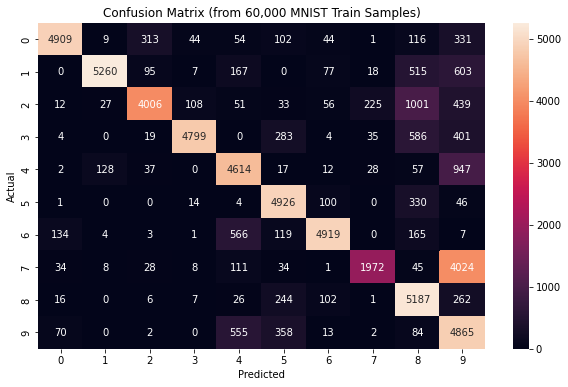

In [44]:
cm = confusion_matrix(y_train_mnist, predictions_train)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (from 60,000 MNIST Train Samples)")
plt.show()

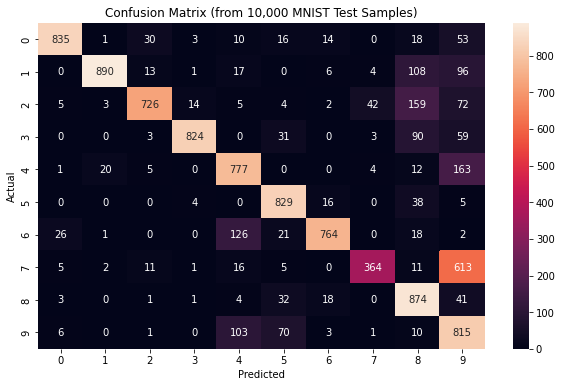

In [45]:
cm = confusion_matrix(y_test_mnist, predictions_test)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (from 10,000 MNIST Test Samples)")
plt.show()

In [46]:
SAVED_MODEL = "saved_models/CNNModel"
tf.saved_model.save(model, SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/CNNModel/assets


INFO:tensorflow:Assets written to: saved_models/CNNModel/assets


# Export model 3 (CNN)

In [ ]:
# Export model
!pip install tinymlgen
from tinymlgen import port

In [ ]:
print(port(model, variable_name='tflite_model_cnn_28', pretty_print=True, optimize=False))

INFO:tensorflow:Assets written to: /tmp/tmpte7vzya8/assets


INFO:tensorflow:Assets written to: /tmp/tmpte7vzya8/assets



#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char tflite_model_cnn_28[] DATA_ALIGN_ATTRIBUTE = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 
	0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 
	0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x18, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x4c, 0x01, 0x00, 0x00, 
	0x2c, 0x00, 0x00, 0x00, 0xf4, 0x00, 0x00, 0x00, 0x68, 0x00, 0x00, 0x00, 
	0x05, 0x00, 0x00, 0x00, 0xfc, 0x05, 0x00, 0x00, 0x14, 0x05, 0x00, 0x00, 
	0x44, 0x04, 0x00, 0x00, 0x6c, 0x03, 0x00, 0x00, 0x08, 0x02, 0x00, 0x00, 
	0x01, 0x00, 0x00, 0x00, 0x44, 0x01, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 
	0x64, 0x0b, 0x01, 0x00, 0x60, 0x0b, 0x01, 0x00, 0x60, 0x

In [ ]:
img = X_train_mnist[4]
print(img.shape)

display_single(img)
display_single(preprocess_mnist_for_cnn(img))